# Introduction and presentation 



This project is about classification. We want to uplaod a model which can be able to classify some fruit and vegetable thanks to image recognition. For that, we would use the librairie fastai and create a small convolutional network.  

In order, to do so we would first load the data, then create a model of 34 layers of a convolutional network. The second step we would find a learning rate and choose the optimal in order to train our model the optimal way. 

We would then want to check in our model is efficient enough with a Confusion Matrix. 

Finally, we would test our model and see if this model is capable of recognize a unseen image and to guess which kind is it. 

We choose pictures of : 
> Mango, peach, pear, pitaya, apple, banana, guava, kiwi, orange and tomato 

# Importation

In [3]:
!pip install "torch==1.7" "torchvision==0.8"
#!pip install interpret
#!pip install interpolation

     |████████████████████████████████| 11.8MB 8.4MB/s 
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [4]:
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch 
import math
#import interpret as interpret


# Load the data

Here we use "ImageDataBunch", in order to get the data and split them randomnly into three parts : the train, the validation and the test. The amount in the test folder would be appoximatively 30% of the amount of the train. The validation folder would be around 10% of the train and would be used during the training of the model. We also impose the size of the images and the batch. 

In [5]:
data = ImageDataBunch.from_folder(path="/content/drive/MyDrive/data/Essai200", train="train", test="test", valid_pct = 0.25, ds_tfms=get_transforms(), size=224, bs=16)


In [6]:
data.normalize()

ImageDataBunch;

Train: LabelList (1499 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Pitaya,Pitaya,Pitaya,Pitaya,Pitaya
Path: /content/drive/MyDrive/data/Essai200;

Valid: LabelList (499 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
banana,kiwi,Pear,apple,orange
Path: /content/drive/MyDrive/data/Essai200;

Test: LabelList (302 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/data/Essai200

Let's see how our dataset looks like. 



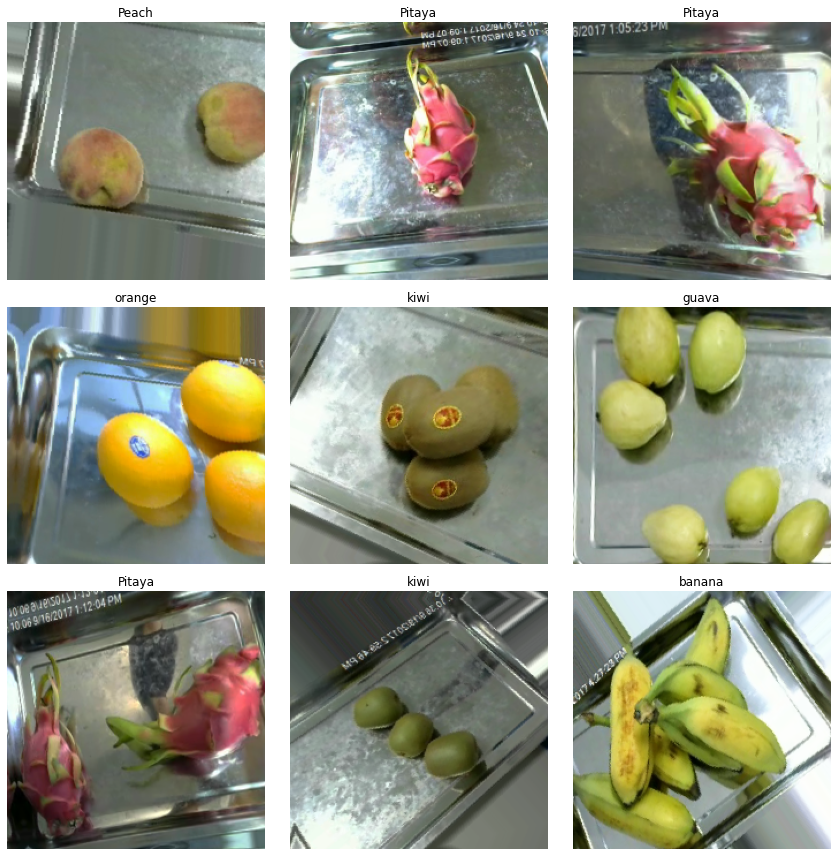

In [7]:
data.show_batch(3)

# Create a model

With fastai we can create easily models with a specific number of layers. The functionnality of fastai would generate itself a pretrain model. The layers have been trained with a very large dataset and by others before. 

We can test to modify the numbers of layers in order to optimize our model. 

We have started with 34, as a pretty casual number of layer. 

In [8]:
learn = cnn_learner(data, models.resnet34, metrics = accuracy)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

# Find the learning rate

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


We plot a graph with as y we have the train loss and as x we have the learning rate. We are looking for the place on the curve where the slope is the biggest. 

A red dot would guide us to choose the optimal learning rate. 

Min numerical gradient: 1.74E-03
Min loss divided by 10: 8.32E-03


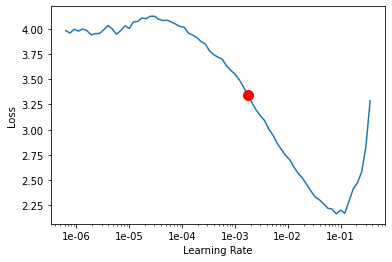

In [10]:
#plot = learn.recorder.plot(suggestion=True)
#plt.legend("Learning rate according to the loss", "Optimal learning rate", loc='upper right')
#plt.title('In quest of the optimal learning rate')
#print(plot)

fig = learn.recorder.plot(suggestion=True)
#fig.s

We look at the graph and we choose ourself the best learning rate for our model. The red dot indicates us the best possible solution. 

# Choose the learning rate

In [11]:
lr = learn.recorder.min_grad_lr
lr = 3.e-3

# Train the model and observation through the epoch

We saw pretty quickly that our model overfit when we add too much epochs. With 8 epochs for example, we can reach 0.9999 almost directly. We then decide to choose 2 epochs. 

In [12]:
#learn.fit_one_cycle(8, slice(lr))

In [13]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.639656,0.031871,0.985972,02:38
1,0.240056,0.027099,0.993988,00:23


We want to show now the result of the validation set. This set is an inside test in the train. It means that throught each epoch the model would take pictures put aside at the beginning in order to the test to model. 

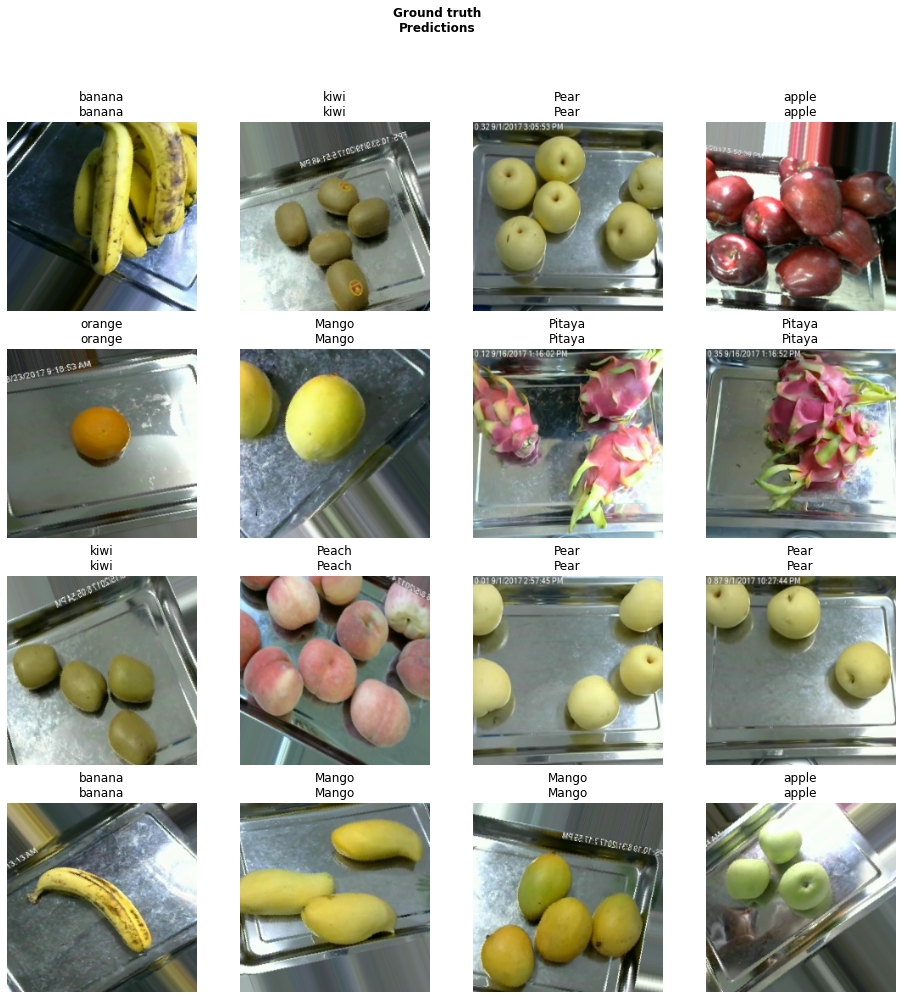

In [14]:
learn.show_results(ds_type=DatasetType.Valid, nrows=6)

# Error and Confusion Matrix 

In this section, we would visualize the biggest mistakes of our model and the confusion matrix. This would first show us what kind of mistakes the model does and the gravity of the mistake. Then we would see the total amount of mistakes generated by during the training. 

And at the end of this section, we will save the model in the folder "models". 

In this cell below, we just create an object that we are going to use later for the top losses and confusion matrix. 

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

This function below shows the where the model is making the most mistakes. The heatmap is an interesting way to show where in the picture the model is taking the pixel in order to work on it and to guess what kind of vegetable or fruit it is. 

Here below we can see different type of pictures. For example, for a picture with an amount of vegetable, the model would take a few in consideration and one strongly than the others. Or, for a mandarine it would take a particular angle. Maybe where it can sees the texture of the skin better in order to diffrenciate it from an apple or a tomato. 

Above the pictures, we can see some writtings. We can read first what the model predict, than the reality. This shows us direclty the mistake. Then we have the loss. When the loss is close to 0, it is not a big mistake but the further it is the biggest the mistake become. And the last number is a probablity that we can translate with the pourcentage of confidence with the model. 

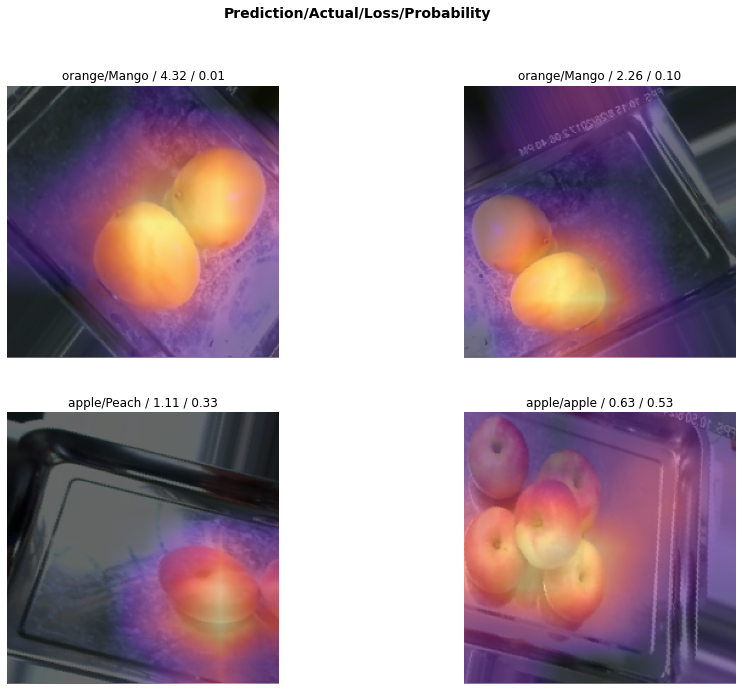

In [16]:
interp.plot_top_losses(4, figsize=(15, 11), heatmap=True)

The amount of data in the confusion matrix is the number of data in the validation set that the model creates automatically. This validation set is used during through the epochs. It is composed of 25% of the trainset with image chosen randomly. 

None


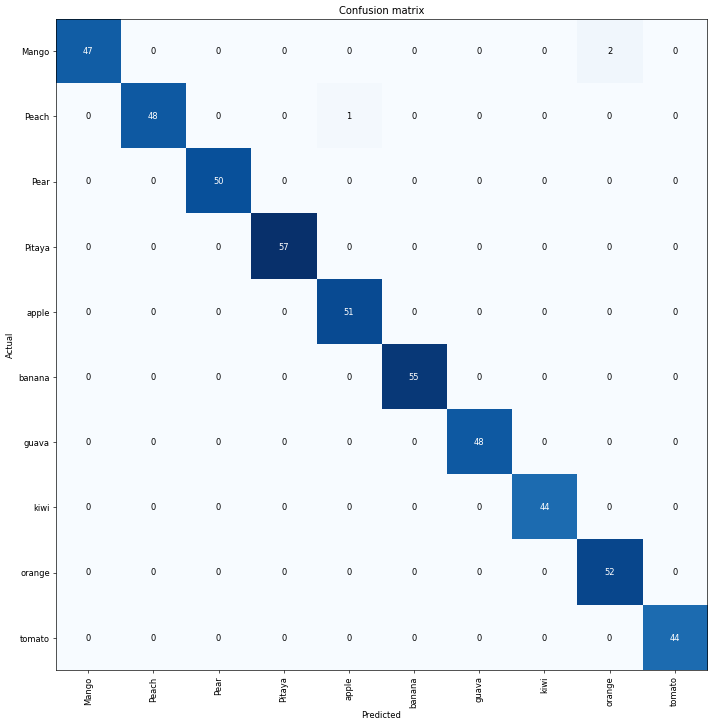

In [17]:
confusion = interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
print(confusion)

This function would show the most mistakes seen in the confusion matrix just above. 

In [18]:
interp.most_confused(5)

[]

### Save the model

Save model (architecture et poid) and optimizer (methode d'optimisation (gradient, ..)

be careful to download it after in a safe place because if the model runs again it will delete it and make a new one. 

In [19]:
learn.save("912_model")

# Model refinement

Here, we want our model to be better optimized. We would use the option of refinement. This technique is to train deeper layers of the model. Every weight are "frozen" except on the last layer. What we would do here is to unfreeze the layer just before the last one and optimize its weigts. 

We add at the beginning a generalist model, then we specialize it with our dataset and our labels and now we refine it. At the end, we are looking for a better accuracy. 


In [20]:
learn.unfreeze()



In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


We plot again the graph of the learning rate according to the loss. We follow the curve until the red dot and take in consideration its value. 

Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.31E-05


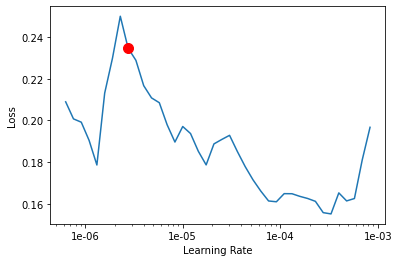

In [22]:
learn.recorder.plot(suggestion=True)


We don't need to train again with too much epoch. We would take only 2. We don't want it to overfit. What is also important is to take a very small learning rate. The learning rate would be taken between 10 times less the initial learning taken earlier and 1000 less. In our case, it would belong to the interval [1e-6, 1e-4]. 

In [23]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.177780,0.010463,0.997996,00:24
1,0.118726,0.007607,0.997996,00:24


# Test

### Test on one image 

We test it on only one image of one category. This process would just give us an idea of the accuracy of the model before the loop. 

In [24]:
img = open_image('/content/drive/MyDrive/data/Essai200/test/Guava/Guava201.png')

In [25]:
y_pred = learn.predict(img)

In [26]:
category = data.classes[y_pred[1].item()]

In [27]:
print(category)

guava


### First loop

Now we do a loop through all the folder of the category 

We want to the ratio and the score after the prediction 

In this loop we compare the result with the name of the folder, it is not really precise but it is the first step before something more accurate. 

It can give us an overview of the accuracy and the efficiency of our model. 

In [31]:
import glob 
from sklearn.metrics import accuracy_score 

folders = glob.glob("/content/drive/MyDrive/data/Essai200/test/*")
print(folders)
total_good_classification = 0 
total_files = len(folders)
#img_number = len(folders)
original_classes = ['Guava', 'Mango', 'Peach', 'Pear', 'Pitaya', 'apple', 'banana', 'kiwi','orange', 'tomato']
score = 0

for folder in folders:
  files = glob.glob(folder + "/*.png")
  for file in files: 
    img = open_image(file)
    y_pred = learn.predict(img)
    category_pred = data.classes[y_pred[1].item()]
    print(file, category_pred)
    folder_name = folder.rsplit('/', 1)[1]

    if category == folder_name:
      total_good_classification += 1

score = total_good_classification / total_files

 

print(score )


['/content/drive/MyDrive/data/Essai200/test/kiwi', '/content/drive/MyDrive/data/Essai200/test/Guava', '/content/drive/MyDrive/data/Essai200/test/Pitaya', '/content/drive/MyDrive/data/Essai200/test/Mango', '/content/drive/MyDrive/data/Essai200/test/Pear', '/content/drive/MyDrive/data/Essai200/test/banana', '/content/drive/MyDrive/data/Essai200/test/tomato', '/content/drive/MyDrive/data/Essai200/test/orange', '/content/drive/MyDrive/data/Essai200/test/apple', '/content/drive/MyDrive/data/Essai200/test/Peach']
/content/drive/MyDrive/data/Essai200/test/kiwi/Kiwi00201.png kiwi
/content/drive/MyDrive/data/Essai200/test/kiwi/Kiwi00203.png kiwi
/content/drive/MyDrive/data/Essai200/test/kiwi/Kiwi00202.png kiwi
/content/drive/MyDrive/data/Essai200/test/kiwi/Kiwi00219.png kiwi
/content/drive/MyDrive/data/Essai200/test/kiwi/Kiwi00210.png kiwi
/content/drive/MyDrive/data/Essai200/test/kiwi/Kiwi00215.png kiwi
/content/drive/MyDrive/data/Essai200/test/kiwi/Kiwi00204.png kiwi
/content/drive/MyDrive/da

We decided to print each result in order to visualize the accuracy with words not numbers for now. In order to read this list correctly, we need to compare the name of the folder and the prediction made by the test on the images. 

For example:   

/ content/ drive/ MyDrive/ data/test/<font color='green'>tomato</font>/apple_93.jpg   <font color='green'>apple</font>

The two words in pink are the ones to be compared to each other. In this example, we can see that the model has made an error. 

# Prediction 

This part is an optional part. It's an alternative of the test function shown earlier. It's a try of a way to make predictions.



In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)
preds

# Steps of project


The goal of the projet is to build a model able to recognize a vegetable or fruit and to classify it. We processed in a few steps in order to get the result we wanted. 

We choose to use the fastai librairy of functionnalities because it was the fastest for our subject. In a previous courses we saw the keras library but it would ask us to build manually the model and define one by one the layers. Here we can just set the parameters and the model it's building itself in a very short time. So, here we choose to work with 34 layers. 

We also decided to save our model each time before any modications or optimization in order to compare. 

First, we wanted to build to model with a small dataset. We just wanted every functionnality to be working well on a few images. After having run it without mistake, we could quickly observe some overfitting. Because of the small amount of images, the model couldn't learn anymore and got used to some images. So the prediction was wrong but the model worked and the confusion matrix too. 

Secondly, we upload a lot more images for each classe. We saw unfortunatly that we are faceing the same problem of overfitting. After a lot of test, we realize that the week was over and we would need a bit more time to achieve a better score. But the model is working even the overfitting. 

We have a few hypothesis about the origin of the overfitting. We would think that the overfitting would come from our dataset. We have found a very big dataset of fruits and vegetables but the pictures were maybe too similar and the angle of each fruits and vegetables were all exploited but with every time a very slight difference. The second hypothesis would be the number of layers of our model or maybe the precision of our learning rate. We are still looking for a solution, soon we'll find it. 


# Conclusion

We have learned here how to manipulate a bit of the fastai funcitionnalities. We have been able to create a classification model, step by step with our specific dataset. We didn't completly achieve our goal but we learned a lot. We would also be happy to found out more about fastai and to finally achieve to find a proper accuracy. 